# Scientific Programming 
## Project 3

In [1]:
import sklearn
import numpy as np
import pandas as pd      # built on top of numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns    # built on top of matplotlib
from pandas.api.types import CategoricalDtype # enables specifying categorical agetype below
import warnings
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions

In [2]:
sns.set_context("paper")
sns.set(font="serif")
sns.set(font_scale=1.5)

# Loading the dataset for Exploration
"diabetes2.csv" is loaded into the dataframe df.

In [3]:
df = pd.read_csv("diabetes2.csv")
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
insu     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Focus on Class
First, let us understand the class variable. This variable is the response variable.  It should be categorical

In [6]:
df['class'] = pd.Categorical(df['class'])
df['class'].describe()

count     768
unique      2
top         0
freq      500
Name: class, dtype: int64

In [7]:
df['class'].value_counts()

0    500
1    268
Name: class, dtype: int64

The class has 500 observations with value 0 and 268 with value 1. Here 1 stands for the patients with diabetes and 0 for the patients without diabetees

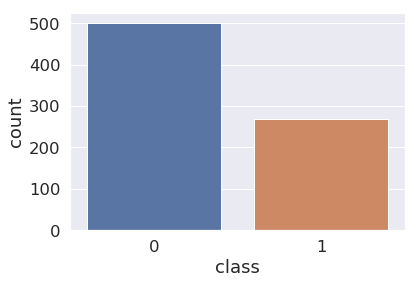

In [8]:
sns.countplot(df['class'])

## Preparing the data to understand the behaviour of the predictors
Creating a new dataframe removing the class variable. Also removing all the zeros from the variables to understand the pairwise correlation of the variables. Zero values for plas, pres, skin, insu and mass are considered to be invalid. 

In [9]:
df_pred = df.drop(['class'],axis=1)
df_pred = df_pred.replace(0,np.NaN)
df_pred = df_pred.dropna()
df_pred.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,3.851190,122.279762,70.244048,28.663690,155.348214,32.297321,0.518702,31.836310
std,3.148352,30.784649,12.363401,10.249863,118.777281,6.368558,0.327689,10.458446
min,1.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,21.000000,76.000000,27.800000,0.268000,24.000000
50%,3.000000,119.000000,70.000000,28.500000,125.500000,32.750000,0.446500,28.000000
75%,6.000000,144.000000,78.000000,36.000000,190.000000,36.250000,0.688250,38.000000
max,17.000000,197.000000,110.000000,52.000000,846.000000,57.300000,2.329000,81.000000


In [10]:
def heatMap(df1):
    corr = df1.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    dropSelf = np.zeros_like(corr)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

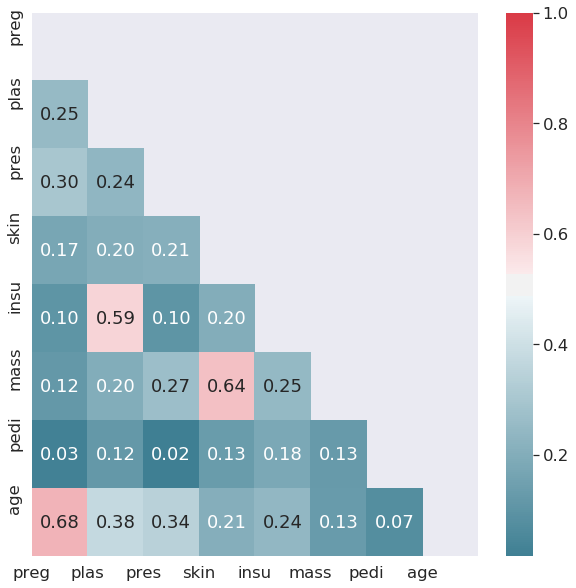

In [11]:
heatMap(df_pred)

From the above correlation plot it is clear that insulin is highly correlated with plasma and skin is highly correlated with body mass index. Also age is higly correlated with the number of pregnancies. 
Insulin and plasma measure the same biological process. 
Body mass index and skin also measure the same biological process.
Hence, we have to drop one of columns from the above two pairs. 
We will keep both age and preg because they are good predictors for the diabeties. 

In [12]:
# Creating a function which will take the dataframe and the predictor to be studied w.r.t to the response variable. 
# We will print the summary startistics for the predictor under consideration and also correlation of the predictor w.r.t
# the other variables. We will try to understand the type of distribution w.r.t to the response variable. 

def describe_var(df,pred,resp_var):
    
    print('\nAnalyzing the missing of the variable --',pred)
    print('\nDescrbing the variable',pred,'we are exploring')
    print(df[pred].describe())
    print('\nCorrelating with all other variables ')
    print(df.corrwith(df[pred]))
    print('\ncount of zero values is',df[df[pred]==0][pred].count())
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

    sns.distplot(df[df[resp_var]==1][pred], label='Class 1', ax=ax1).set_title('Plotting the distribution for the \n'
                                                             +pred+' and the response variable '+resp_var+'\n')
    sns.distplot(df[df[resp_var]==0][pred], label='Class 0', ax=ax1)
    sns.boxplot(x=resp_var, y=pred, data=df,ax=ax2).set_title('Plotting the box plot for the \n'
                                                              +pred+' and the response variable '+resp_var+'\n')
    ax1.legend()
    plt.show()


## Analyzing all the predictor variables
The function describe_var is called on all the predictor variable to understand the behaviour. We are also printing the number of zeros. In some cases it is biologically absurd to have zero values. 


Analyzing the missing of the variable -- preg

Descrbing the variable preg we are exploring
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: preg, dtype: float64

Correlating with all other variables 
preg    1.000000
plas    0.129459
pres    0.141282
skin   -0.081672
insu   -0.073535
mass    0.017683
pedi   -0.033523
age     0.544341
dtype: float64

count of zero values is 111


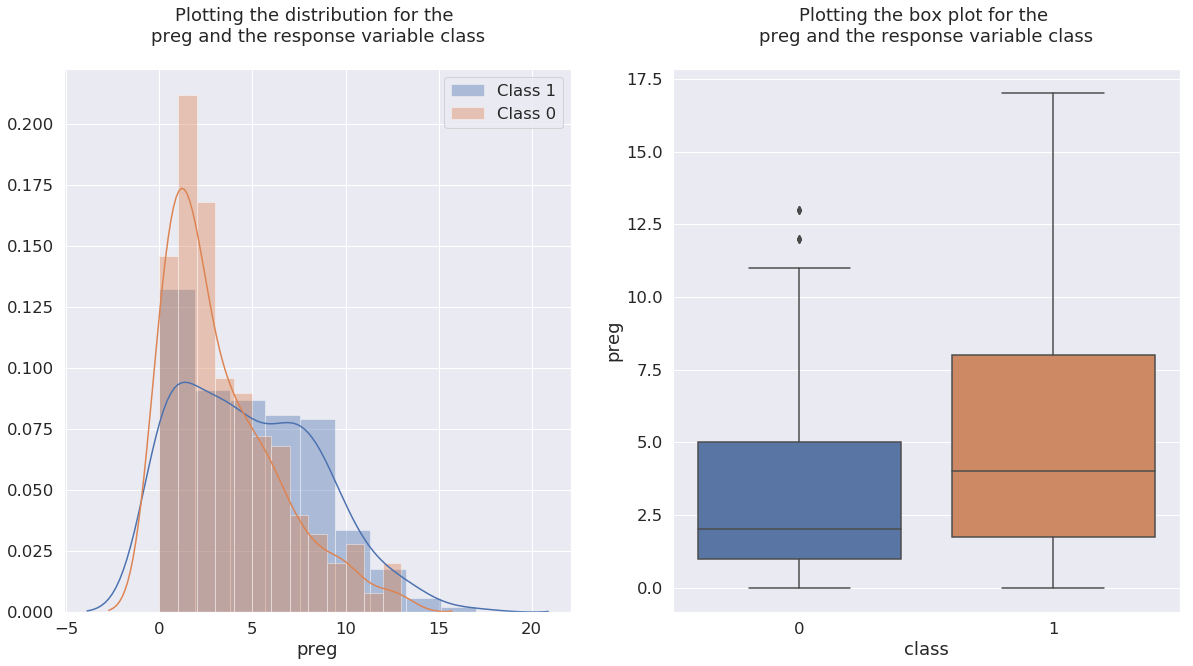


Analyzing the missing of the variable -- plas

Descrbing the variable plas we are exploring
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: plas, dtype: float64

Correlating with all other variables 
preg    0.129459
plas    1.000000
pres    0.152590
skin    0.057328
insu    0.331357
mass    0.221071
pedi    0.137337
age     0.263514
dtype: float64

count of zero values is 5


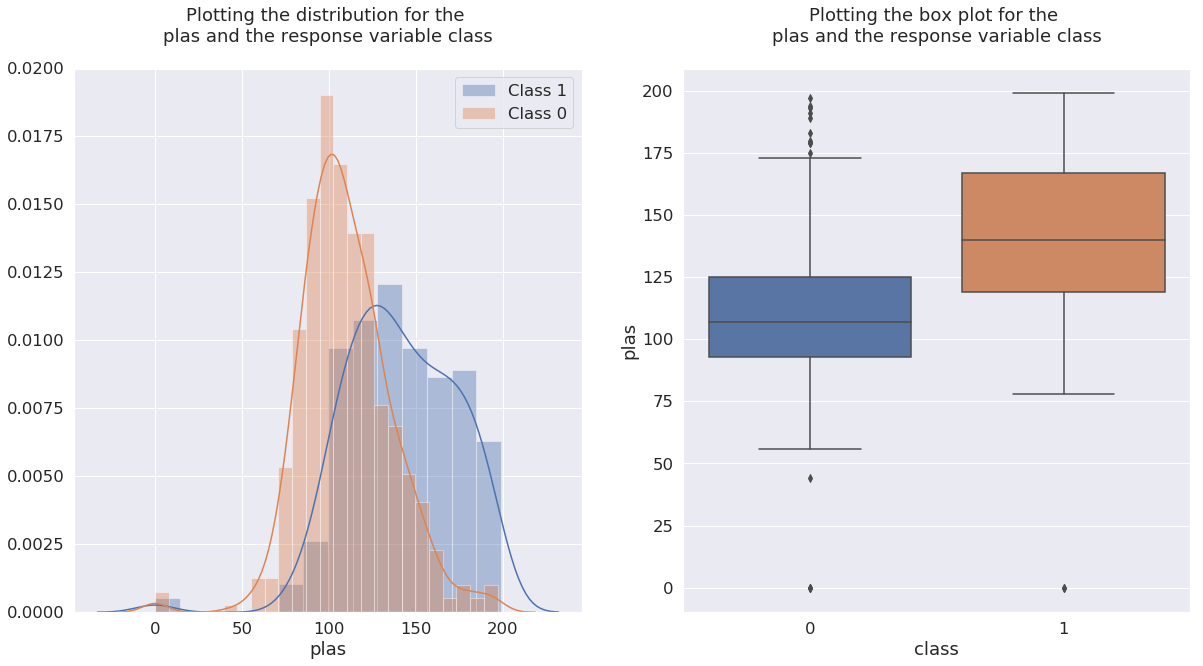


Analyzing the missing of the variable -- pres

Descrbing the variable pres we are exploring
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: pres, dtype: float64

Correlating with all other variables 
preg    0.141282
plas    0.152590
pres    1.000000
skin    0.207371
insu    0.088933
mass    0.281805
pedi    0.041265
age     0.239528
dtype: float64

count of zero values is 35


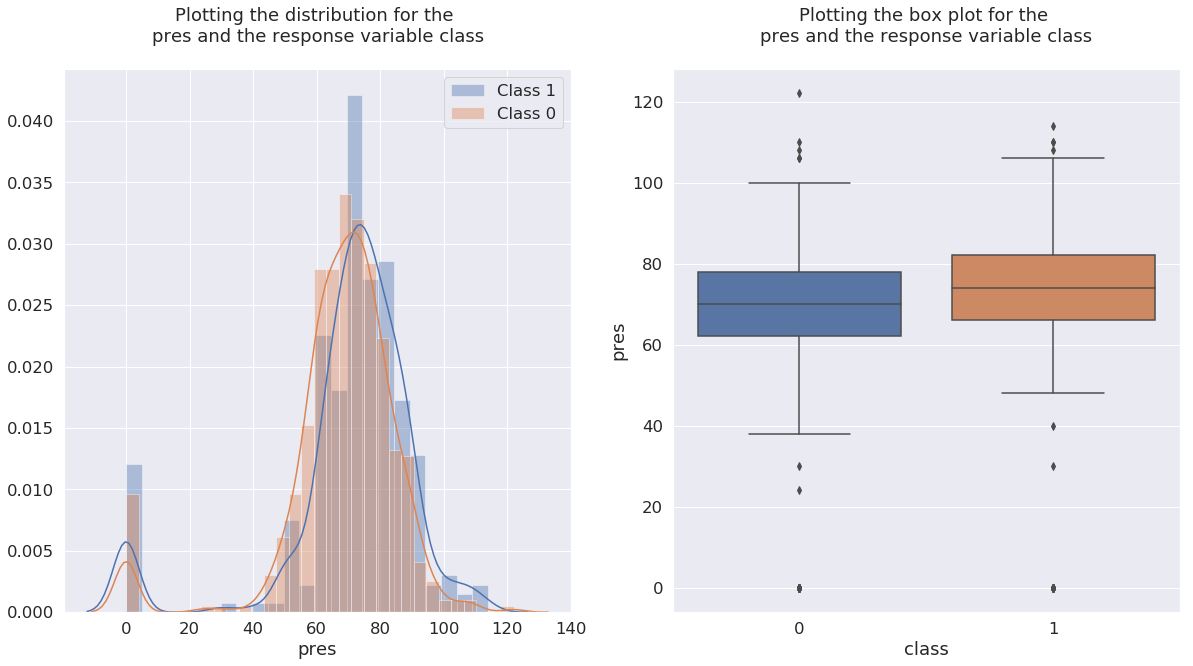


Analyzing the missing of the variable -- skin

Descrbing the variable skin we are exploring
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: skin, dtype: float64

Correlating with all other variables 
preg   -0.081672
plas    0.057328
pres    0.207371
skin    1.000000
insu    0.436783
mass    0.392573
pedi    0.183928
age    -0.113970
dtype: float64

count of zero values is 227


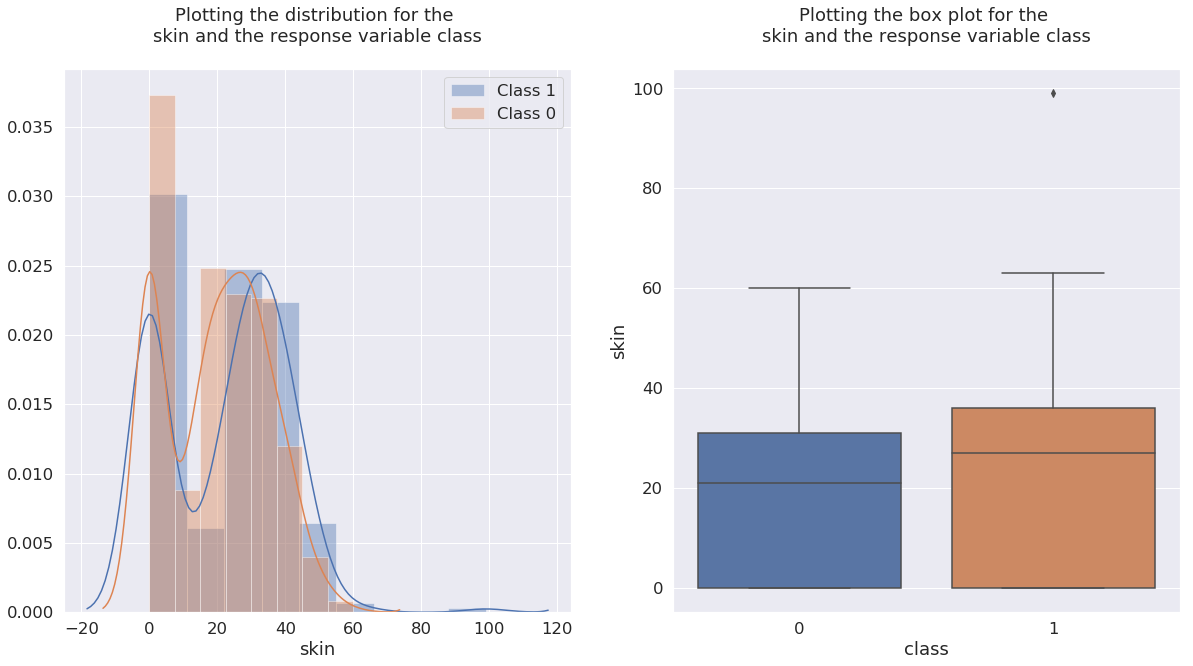


Analyzing the missing of the variable -- insu

Descrbing the variable insu we are exploring
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: insu, dtype: float64

Correlating with all other variables 
preg   -0.073535
plas    0.331357
pres    0.088933
skin    0.436783
insu    1.000000
mass    0.197859
pedi    0.185071
age    -0.042163
dtype: float64

count of zero values is 374


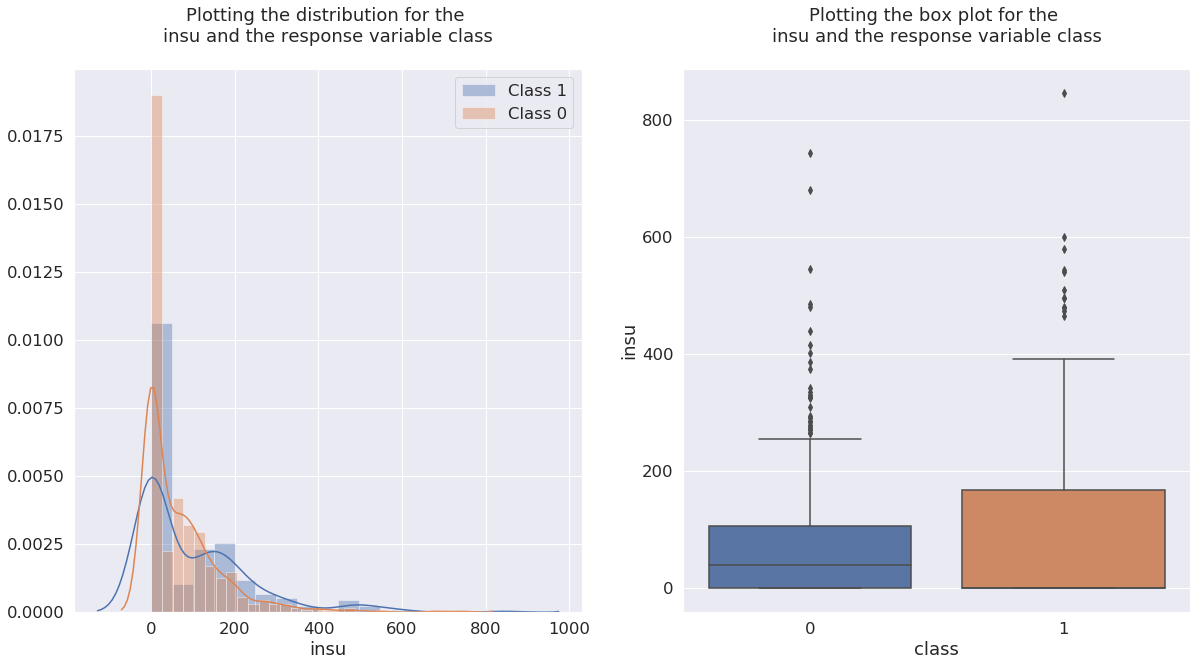


Analyzing the missing of the variable -- mass

Descrbing the variable mass we are exploring
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: mass, dtype: float64

Correlating with all other variables 
preg    0.017683
plas    0.221071
pres    0.281805
skin    0.392573
insu    0.197859
mass    1.000000
pedi    0.140647
age     0.036242
dtype: float64

count of zero values is 11


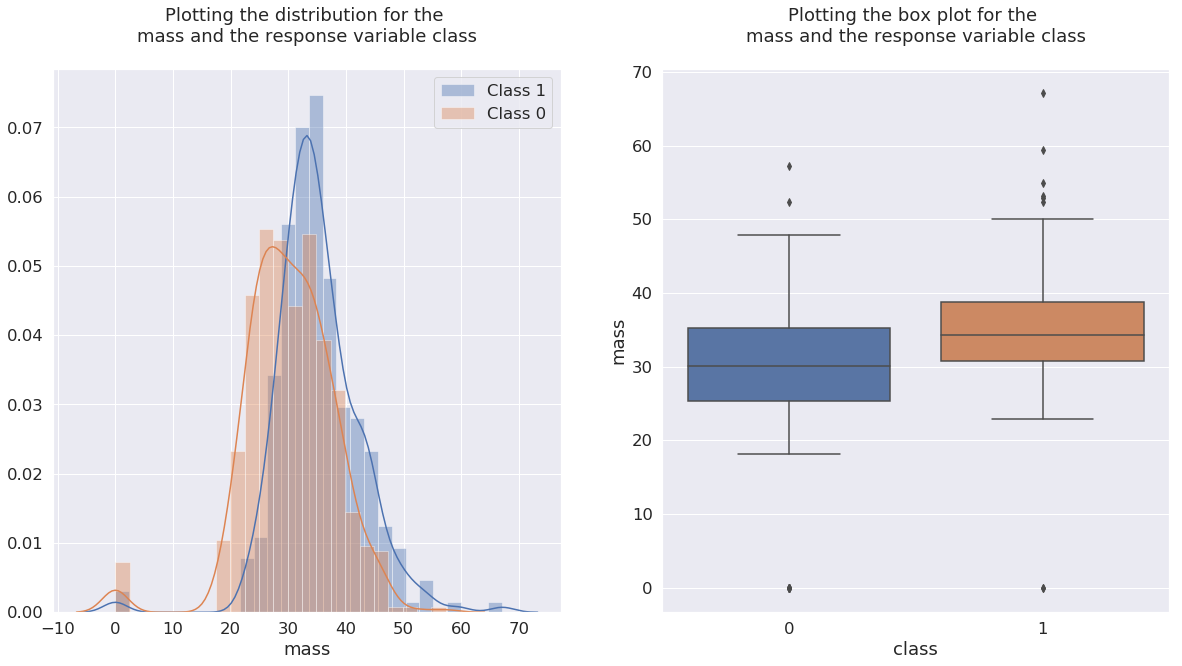


Analyzing the missing of the variable -- pedi

Descrbing the variable pedi we are exploring
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: pedi, dtype: float64

Correlating with all other variables 
preg   -0.033523
plas    0.137337
pres    0.041265
skin    0.183928
insu    0.185071
mass    0.140647
pedi    1.000000
age     0.033561
dtype: float64

count of zero values is 0


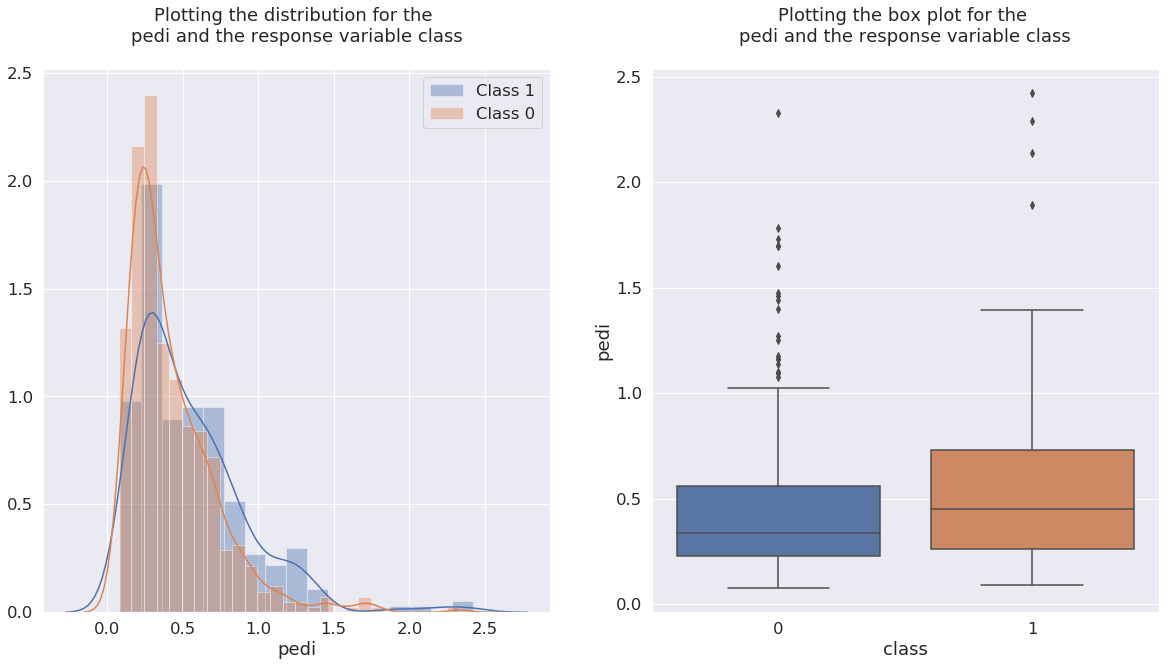


Analyzing the missing of the variable -- age

Descrbing the variable age we are exploring
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: age, dtype: float64

Correlating with all other variables 
preg    0.544341
plas    0.263514
pres    0.239528
skin   -0.113970
insu   -0.042163
mass    0.036242
pedi    0.033561
age     1.000000
dtype: float64

count of zero values is 0


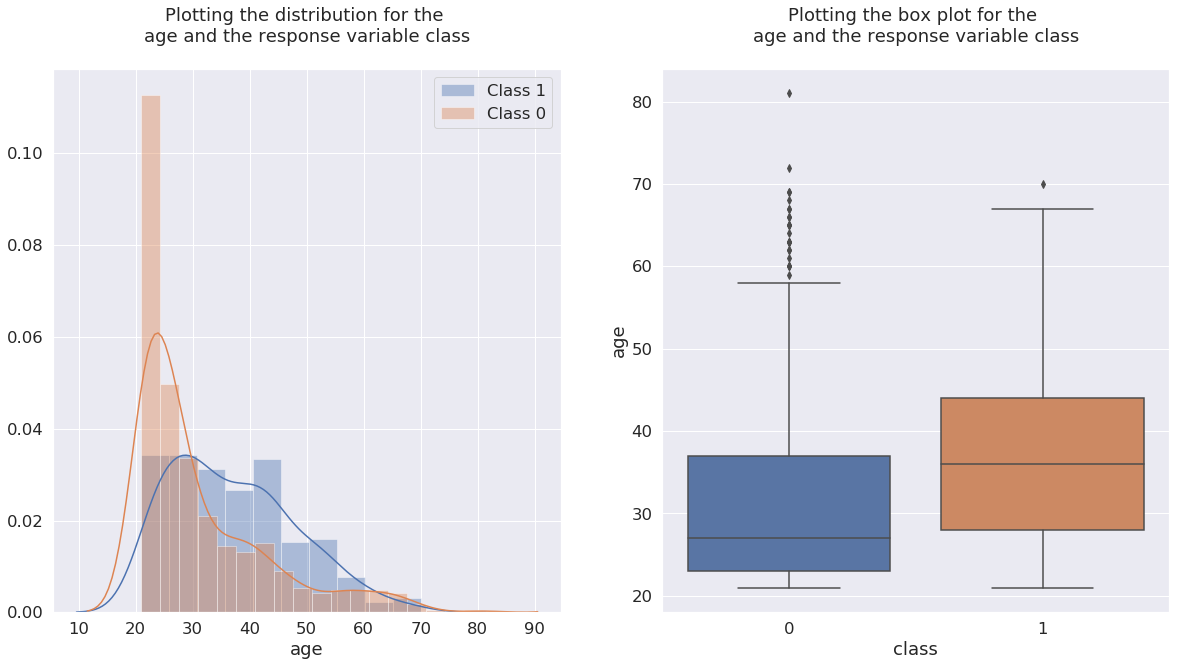

In [13]:
for column in df:
    if column != 'class':
        describe_var(df,column,'class')

In the above plots zero can be treated as an invalid value for the plas, pres, skin and mass. It is also observed that skin has 227 and insu has 374 values. Above we have observed that skin and mass are highly correlated and plas and insu are highly correlated. Given the large number of missing values and the highly correlated nature we can drop  insu and skin from the dataframe. 

In [14]:
df_1 = df.drop(['insu','skin'],axis=1)
df_1.describe()

,preg,plas,pres,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000


## Fixing the invalid zero values
Next we need to fix the invalid zero values for plas, pres and mass. We are going to subsiture the invalid zero value with the median value of the respective class for the variable. 

In [15]:
def fix_invalid_zero(df1,pred,resp_var):
    print('\nFixing the invalid zeros for the variable --',pred)
    df1[pred] = df1[pred].replace(0,np.NaN)
    zero_m = df1[df1[resp_var]==0][pred].median()
    print('Median value for class 0 is',zero_m)
    df1.loc[df1[pred].isna() & (df1[resp_var]==0), pred] = zero_m
    one_m = df1[df1[resp_var]==1][pred].median()
    print('Median value for class 1 is',one_m)
    df1.loc[df1[pred].isna() & (df1[resp_var]==1), pred] = one_m

In [16]:
for col in ['plas','pres','mass']:
    fix_invalid_zero(df_1,col,'class')
    
df_1.describe()


Fixing the invalid zeros for the variable -- plas
Median value for class 0 is 107.0
Median value for class 1 is 140.0

Fixing the invalid zeros for the variable -- pres
Median value for class 0 is 70.0
Median value for class 1 is 74.5

Fixing the invalid zeros for the variable -- mass
Median value for class 0 is 30.1
Median value for class 1 is 34.3


,preg,plas,pres,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,32.434635,0.471876,33.240885
std,3.369578,30.464161,12.106039,6.880498,0.331329,11.760232
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,32.050000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000


In [17]:
df_1.head()

,preg,plas,pres,mass,pedi,age,class
0,6,148.0,72.0,33.6,0.627,50,1
1,1,85.0,66.0,26.6,0.351,31,0
2,8,183.0,64.0,23.3,0.672,32,1
3,1,89.0,66.0,28.1,0.167,21,0
4,0,137.0,40.0,43.1,2.288,33,1


## Final look at the dataset after cleanup
Let us explore the final data frame after fixing all the invalid values and cleaning up the columns


Analyzing the missing of the variable -- preg

Descrbing the variable preg we are exploring
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: preg, dtype: float64

Correlating with all other variables 
preg    1.000000
plas    0.130155
pres    0.209151
mass    0.023890
pedi   -0.033523
age     0.544341
dtype: float64

count of zero values is 111


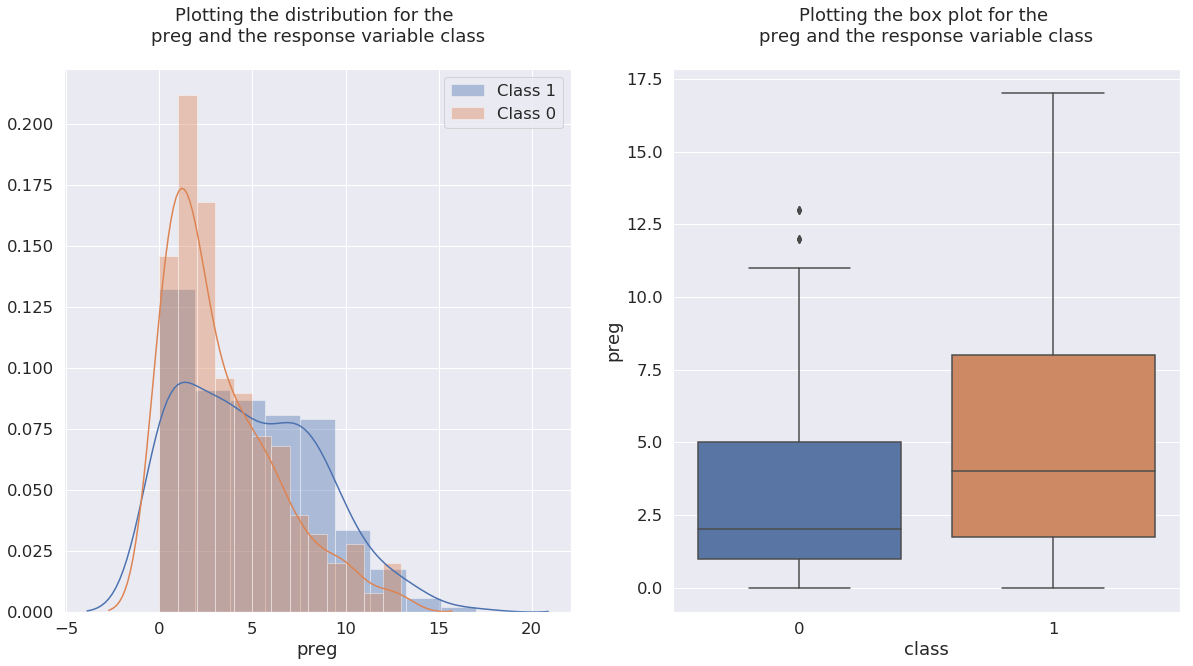


Analyzing the missing of the variable -- plas

Descrbing the variable plas we are exploring
count    768.000000
mean     121.677083
std       30.464161
min       44.000000
25%       99.750000
50%      117.000000
75%      140.250000
max      199.000000
Name: plas, dtype: float64

Correlating with all other variables 
preg    0.130155
plas    1.000000
pres    0.225141
mass    0.236171
pedi    0.138353
age     0.268910
dtype: float64

count of zero values is 0


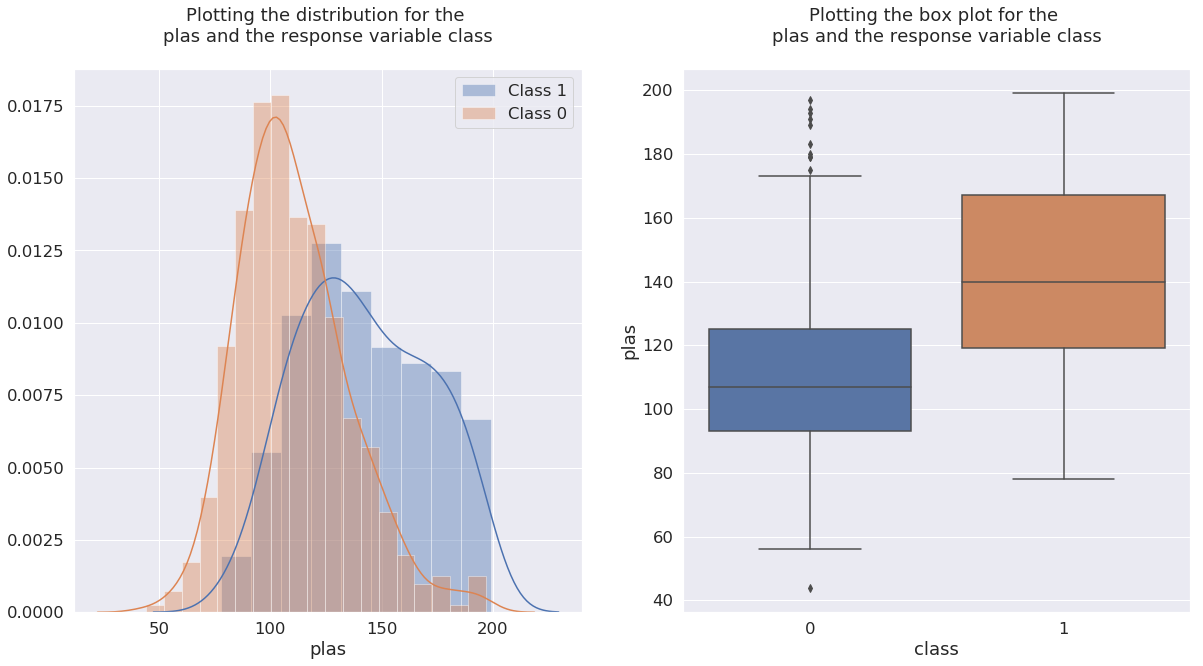


Analyzing the missing of the variable -- pres

Descrbing the variable pres we are exploring
count    768.000000
mean      72.389323
std       12.106039
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: pres, dtype: float64

Correlating with all other variables 
preg    0.209151
plas    0.225141
pres    1.000000
mass    0.286399
pedi   -0.001443
age     0.325135
dtype: float64

count of zero values is 0


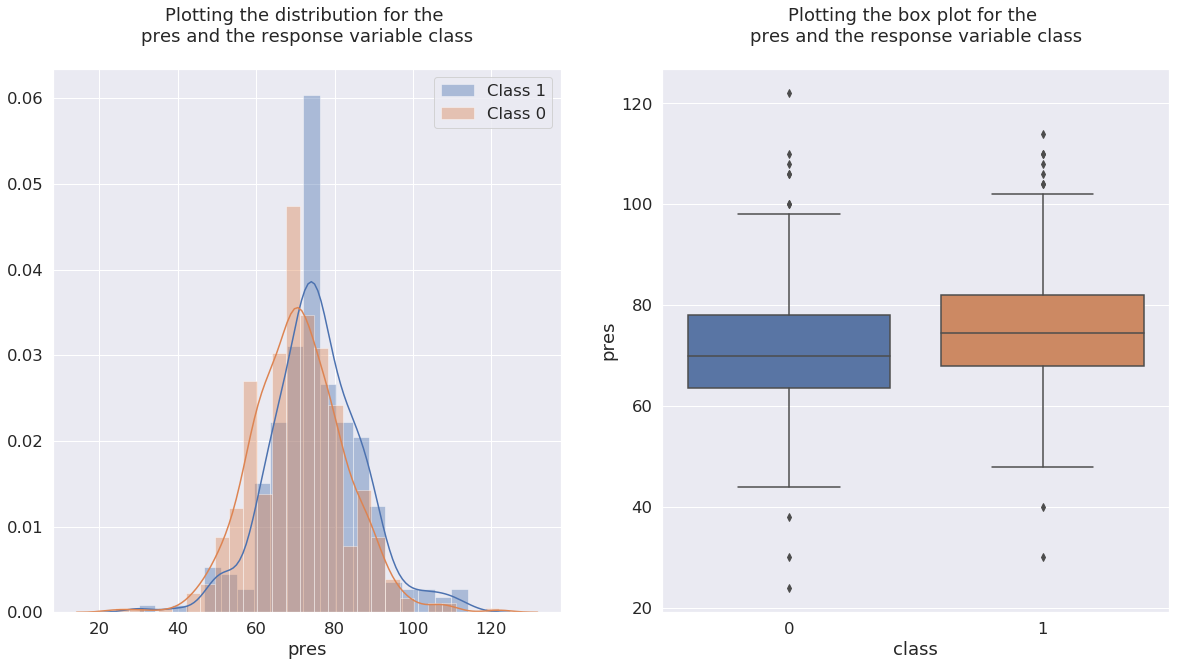


Analyzing the missing of the variable -- mass

Descrbing the variable mass we are exploring
count    768.000000
mean      32.434635
std        6.880498
min       18.200000
25%       27.500000
50%       32.050000
75%       36.600000
max       67.100000
Name: mass, dtype: float64

Correlating with all other variables 
preg    0.023890
plas    0.236171
pres    0.286399
mass    1.000000
pedi    0.152771
age     0.027849
dtype: float64

count of zero values is 0


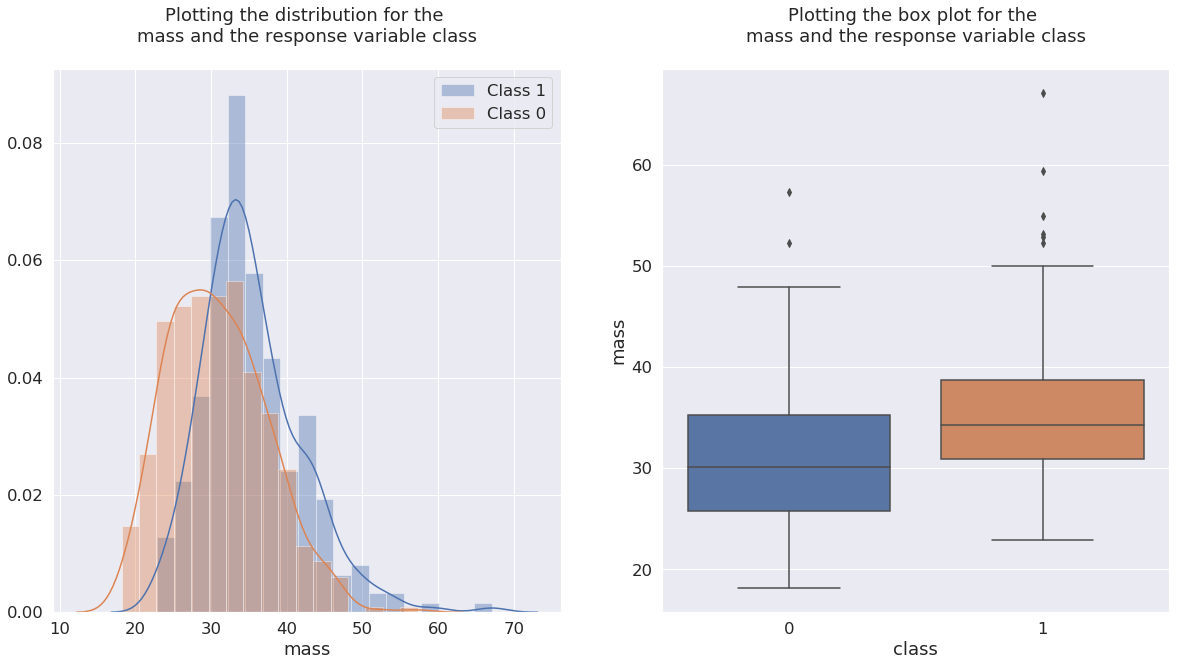


Analyzing the missing of the variable -- pedi

Descrbing the variable pedi we are exploring
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: pedi, dtype: float64

Correlating with all other variables 
preg   -0.033523
plas    0.138353
pres   -0.001443
mass    0.152771
pedi    1.000000
age     0.033561
dtype: float64

count of zero values is 0


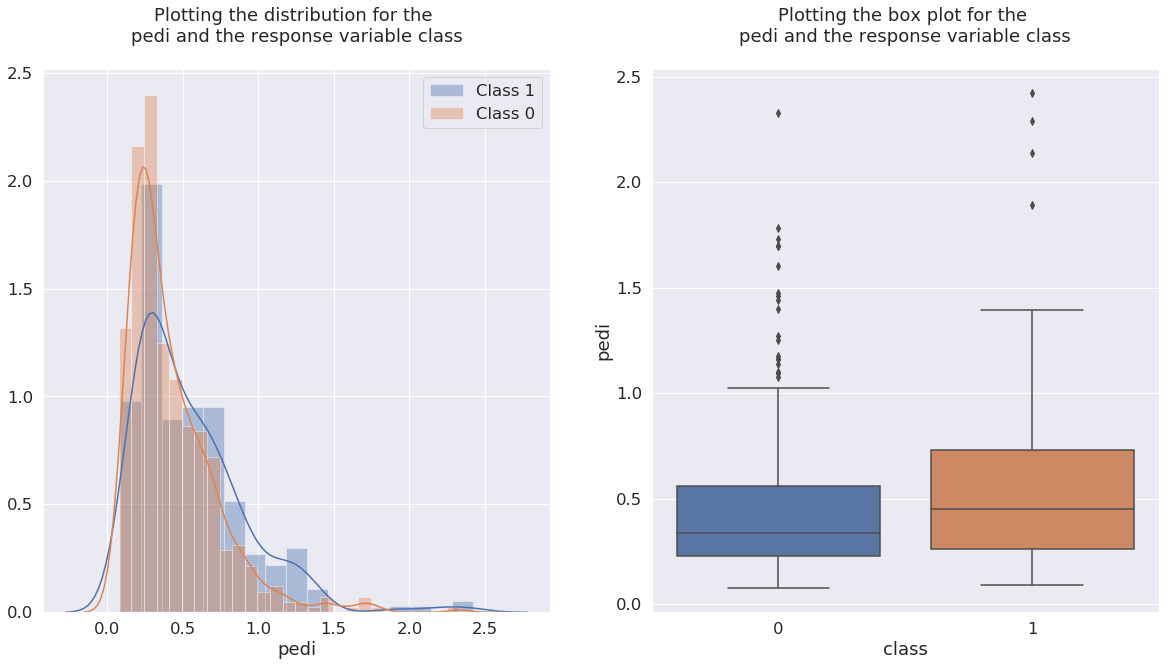


Analyzing the missing of the variable -- age

Descrbing the variable age we are exploring
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: age, dtype: float64

Correlating with all other variables 
preg    0.544341
plas    0.268910
pres    0.325135
mass    0.027849
pedi    0.033561
age     1.000000
dtype: float64

count of zero values is 0


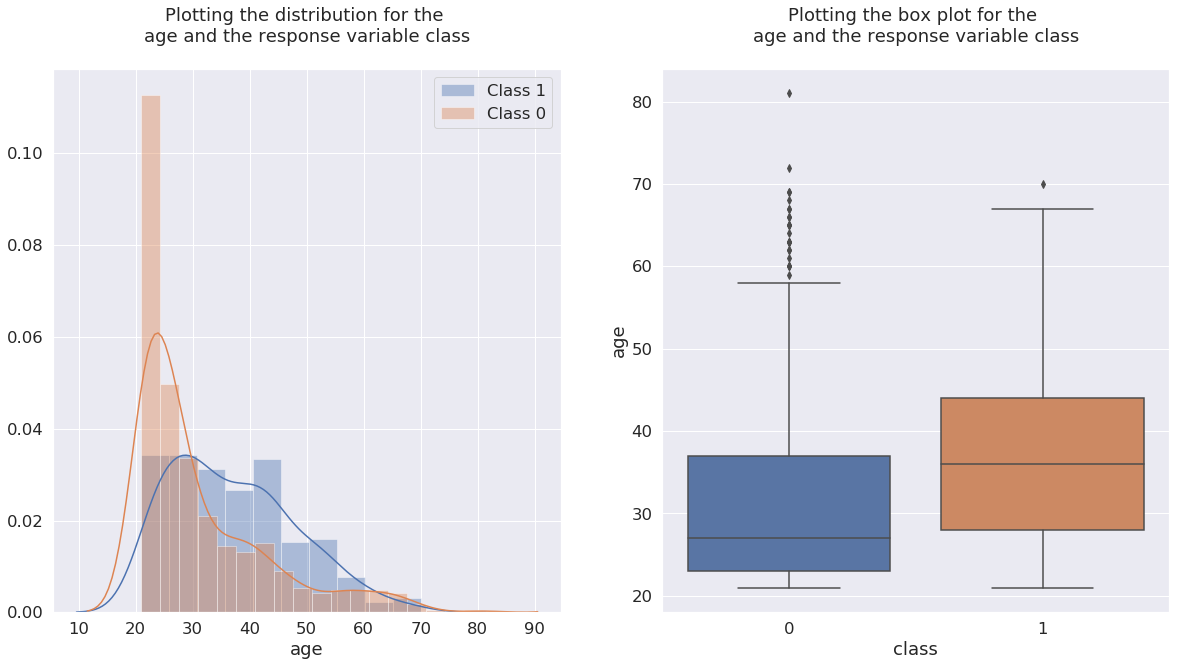

In [18]:
for column in df_1:
    if column != 'class':
        describe_var(df_1,column,'class')

Let us do a pairplot for the final variables

In [19]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
preg     768 non-null int64
plas     768 non-null float64
pres     768 non-null float64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null category
dtypes: category(1), float64(4), int64(2)
memory usage: 36.9 KB


Now the data is all cleaned up and ready for furhter exploration. We will plot pairwise comparision.

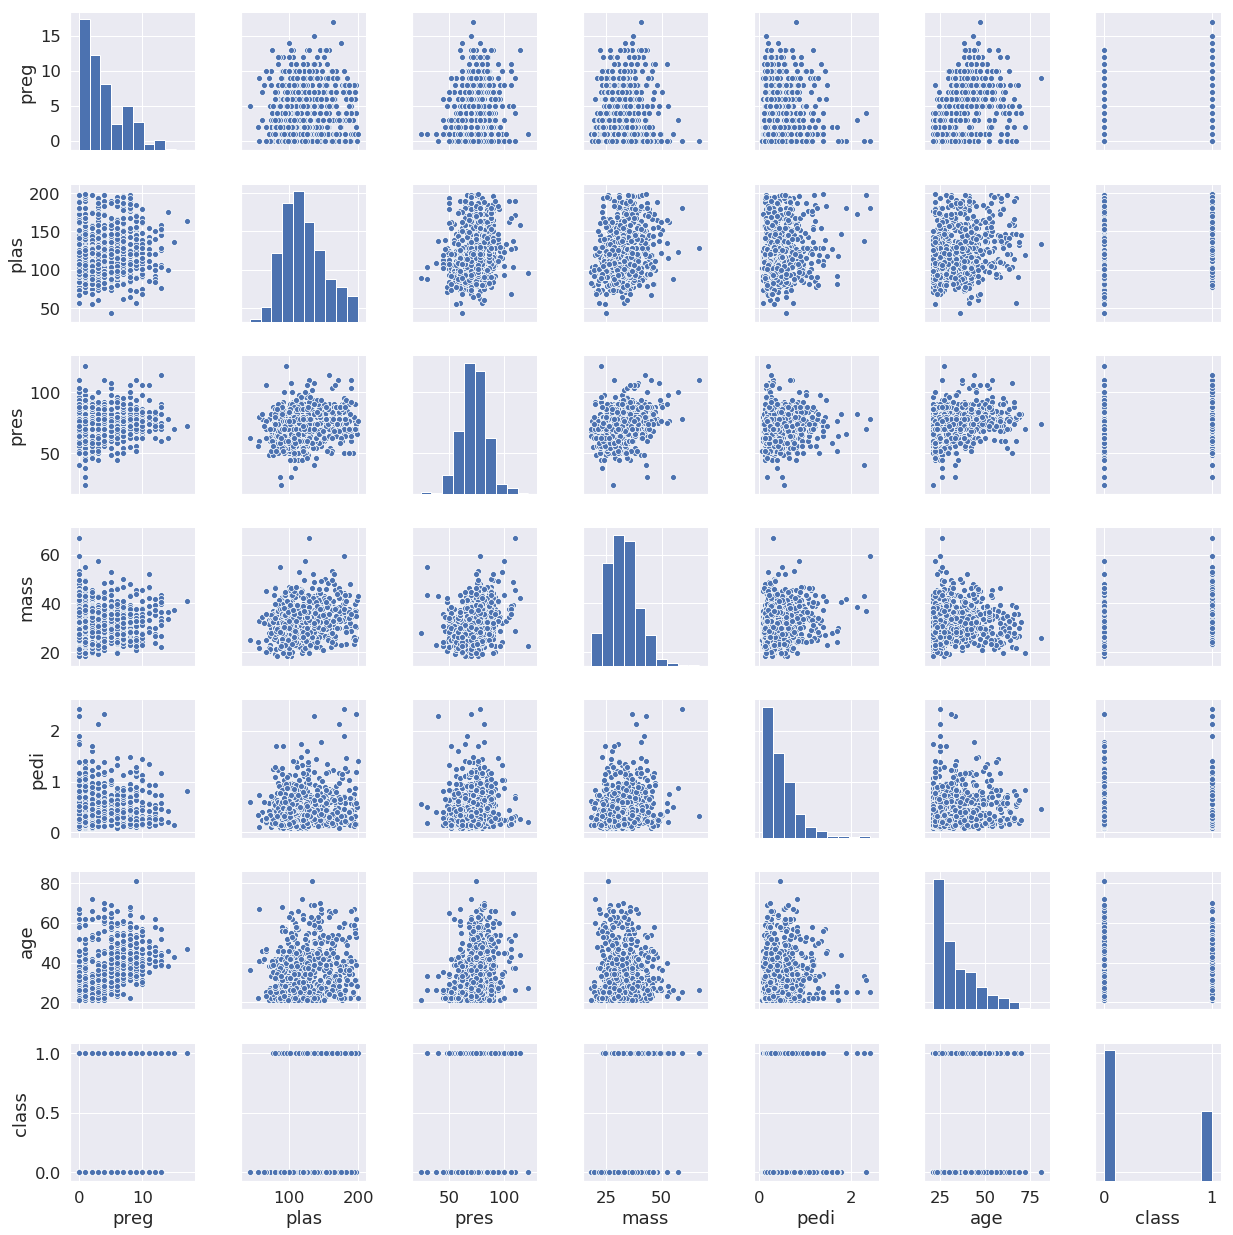

In [20]:
sns.pairplot(df_1)

In this exploration exercise we found that we need to do the following clean up on the dataset
1. Remove the columns skin and insu
2. Replace the invalid zeros for mass, pres, plas variables with the mean of the respective class

The correct approach for the fix to work is to make sure we are doing this only on the train data set which we will use it for building the model to make sure that we are not leaking information from the train to test. 

# Loading the data for Model building
In the exploration we have decided the final set of variables would be preg, plas, pres, mass, pedi and age as predictors and class would be the reponse variable. We will only load these variables. 

In [21]:
df_m = pd.read_csv("diabetes2.csv", 
                   usecols=["preg", "plas", "pres","mass","pedi","age","class"])
df_m.head()

,preg,plas,pres,mass,pedi,age,class
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1


In [22]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


In [23]:
df_m.describe()

,preg,plas,pres,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


### Cleanup
We have seen in our exploration that zero values are not valid for plas, pres and mass. We will set them to mp.NaN and later provide an imputation of these nulls with the median values. 

In [24]:
# Fixing the invalid zero values as NaN before making the train and test split
df_m.plas = df_m.plas .replace(0,np.NaN)
df_m.pres = df_m.pres .replace(0,np.NaN)
df_m.mass = df_m.mass .replace(0,np.NaN)

## Preparing the data for Model Building
We will create a test and train split for 80% train and 20% test split. 

In [25]:
# Creating test and train split.
X = df_m.drop(labels=['class'], axis=1)
y = df_m.loc[:,'class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)
print('Info for X_train is\n')
print(X_train.info())
print('Info for X_test is\n')
print(X_test.info())
print('Info for y_train is\n')
print(y_train.value_counts())
print('Info for y_test is\n')
print(y_test.value_counts())

Info for X_train is

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 678 to 332
Data columns (total 6 columns):
preg    614 non-null int64
plas    611 non-null float64
pres    590 non-null float64
mass    607 non-null float64
pedi    614 non-null float64
age     614 non-null int64
dtypes: float64(4), int64(2)
memory usage: 33.6 KB
None
Info for X_test is

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 488 to 102
Data columns (total 6 columns):
preg    154 non-null int64
plas    152 non-null float64
pres    143 non-null float64
mass    150 non-null float64
pedi    154 non-null float64
age     154 non-null int64
dtypes: float64(4), int64(2)
memory usage: 8.4 KB
None
Info for y_train is

0    400
1    214
Name: class, dtype: int64
Info for y_test is

0    100
1     54
Name: class, dtype: int64


As mentioned above the training data would be imputed with the overall median of the predictor

In [26]:
imp_x = Imputer(missing_values='NaN', strategy='median', axis=0) 
X_train = imp_x.fit_transform(X_train)
X_test = imp_x.transform(X_test) 
print('Contains NaNs in X_train is ',np.isnan(np.min(X_train)))
print('Contains NaNs in X_train is ',np.isnan(np.min(X_test)))

Contains NaNs in X_train is  False
Contains NaNs in X_train is  False


In [27]:
#printing the shape of all the numpy arrays
print('Shape for X_train is',X_train.shape)
print('shape for X_test is',X_test.shape)

Shape for X_train is (614, 6)
shape for X_test is (154, 6)


We will use the same function developed for exploration to make sure that the imputation has gone well and all the values are valid for the predictors.


Analyzing the missing of the variable -- preg

Descrbing the variable preg we are exploring
count    614.000000
mean       3.859935
std        3.401361
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: preg, dtype: float64

Correlating with all other variables 
preg     1.000000
plas     0.134837
pres     0.187045
mass    -0.001401
pedi    -0.041543
age      0.554559
class    0.228266
dtype: float64

count of zero values is 92


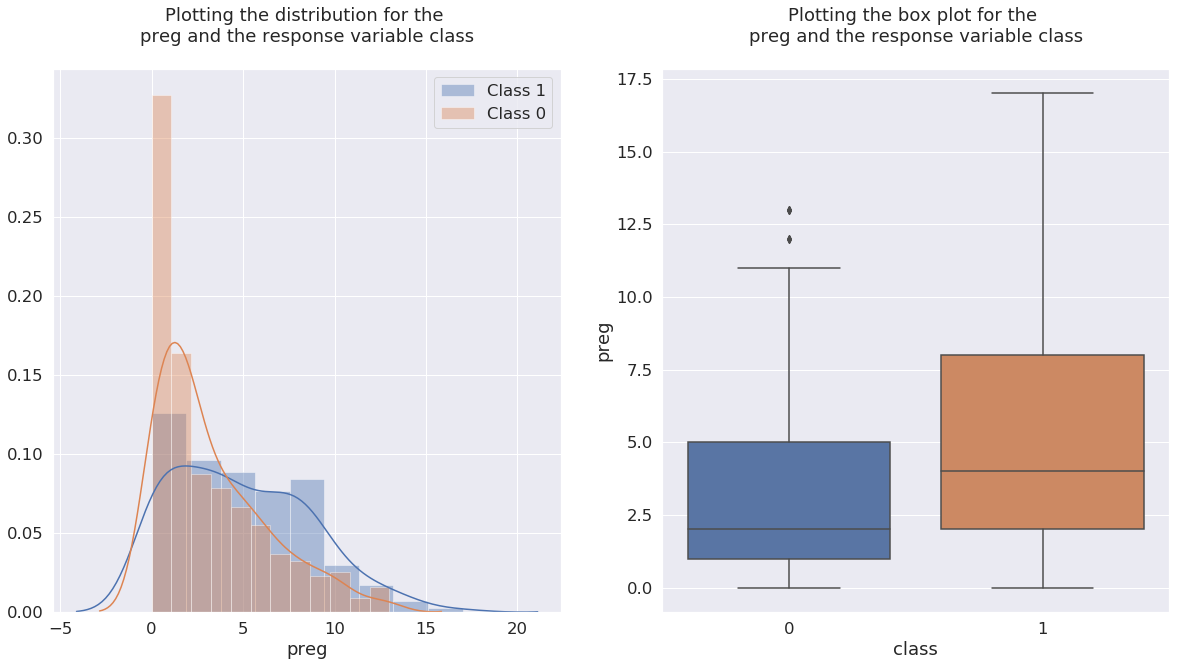


Analyzing the missing of the variable -- plas

Descrbing the variable plas we are exploring
count    614.000000
mean     122.057003
std       30.546758
min       44.000000
25%       99.250000
50%      118.000000
75%      141.750000
max      199.000000
Name: plas, dtype: float64

Correlating with all other variables 
preg     0.134837
plas     1.000000
pres     0.237130
mass     0.221541
pedi     0.156975
age      0.289140
class    0.498974
dtype: float64

count of zero values is 0


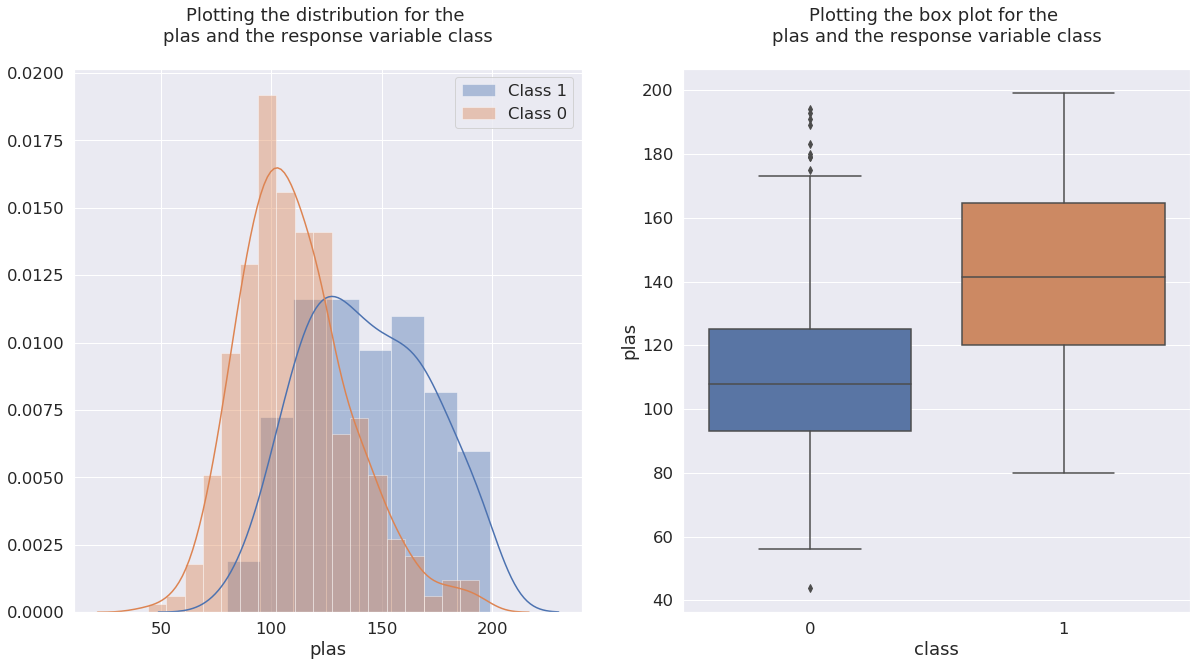


Analyzing the missing of the variable -- pres

Descrbing the variable pres we are exploring
count    614.000000
mean      72.299674
std       11.773893
min       30.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      110.000000
Name: pres, dtype: float64

Correlating with all other variables 
preg     0.187045
plas     0.237130
pres     1.000000
mass     0.297859
pedi    -0.002028
age      0.333449
class    0.178059
dtype: float64

count of zero values is 0


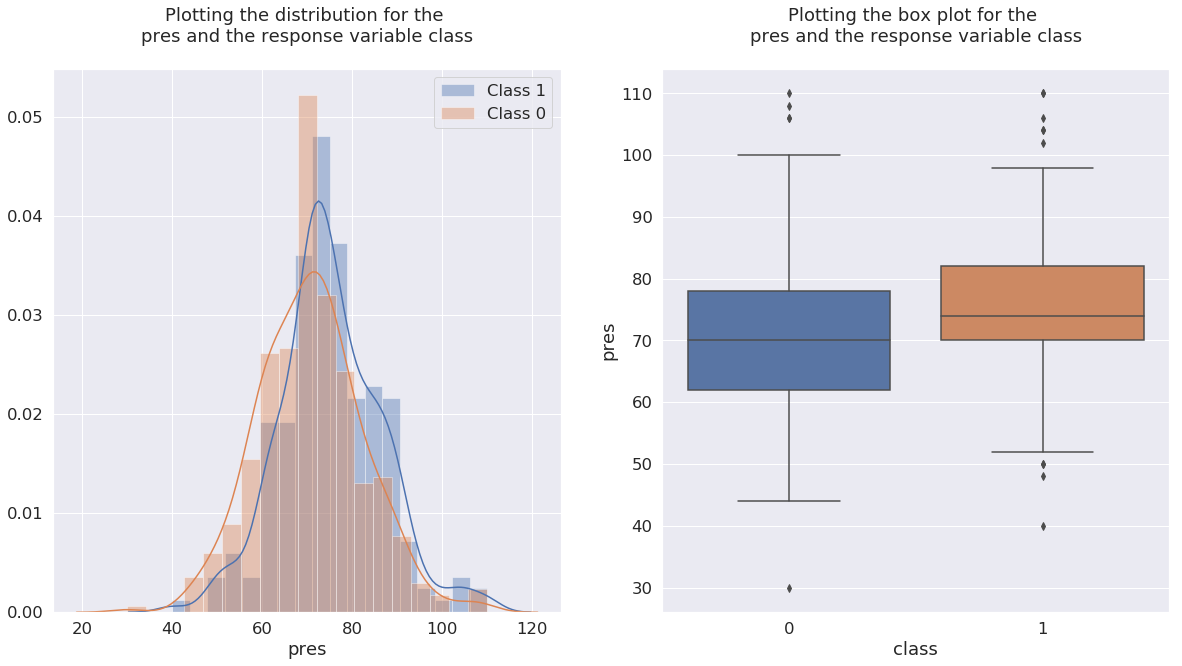


Analyzing the missing of the variable -- mass

Descrbing the variable mass we are exploring
count    614.000000
mean      32.528827
std        6.921393
min       18.200000
25%       27.500000
50%       32.400000
75%       36.600000
max       67.100000
Name: mass, dtype: float64

Correlating with all other variables 
preg    -0.001401
plas     0.221541
pres     0.297859
mass     1.000000
pedi     0.155325
age      0.022280
class    0.300553
dtype: float64

count of zero values is 0


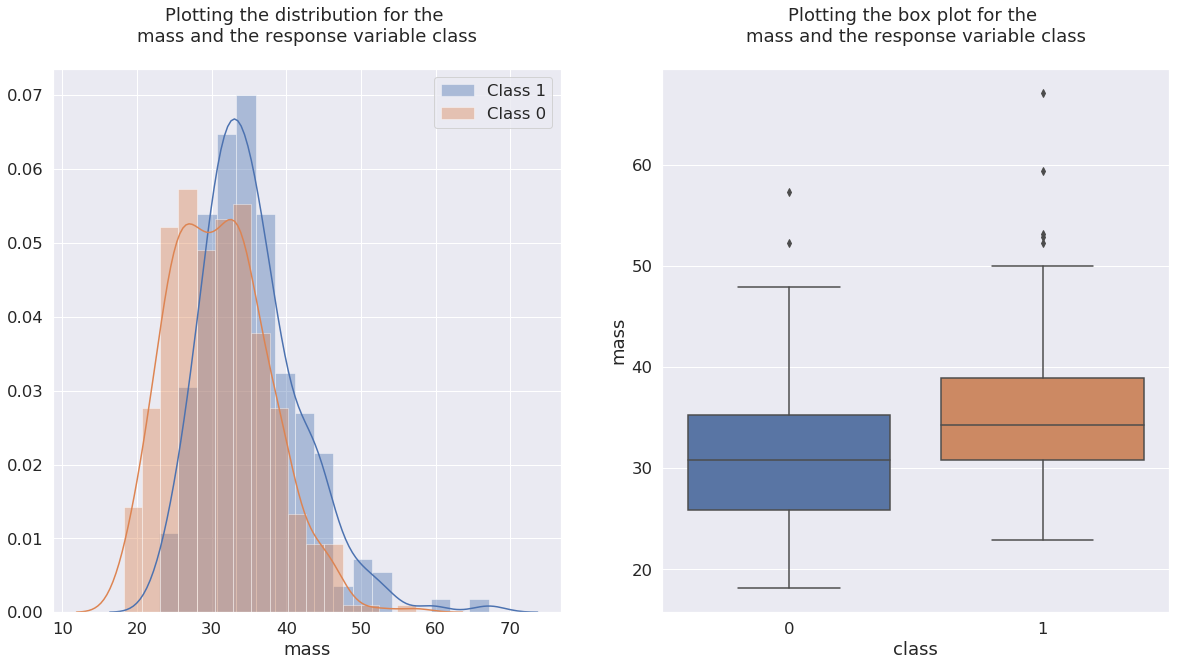


Analyzing the missing of the variable -- pedi

Descrbing the variable pedi we are exploring
count    614.000000
mean       0.475322
std        0.332734
min        0.084000
25%        0.246250
50%        0.369000
75%        0.635500
max        2.420000
Name: pedi, dtype: float64

Correlating with all other variables 
preg    -0.041543
plas     0.156975
pres    -0.002028
mass     0.155325
pedi     1.000000
age      0.024847
class    0.211575
dtype: float64

count of zero values is 0


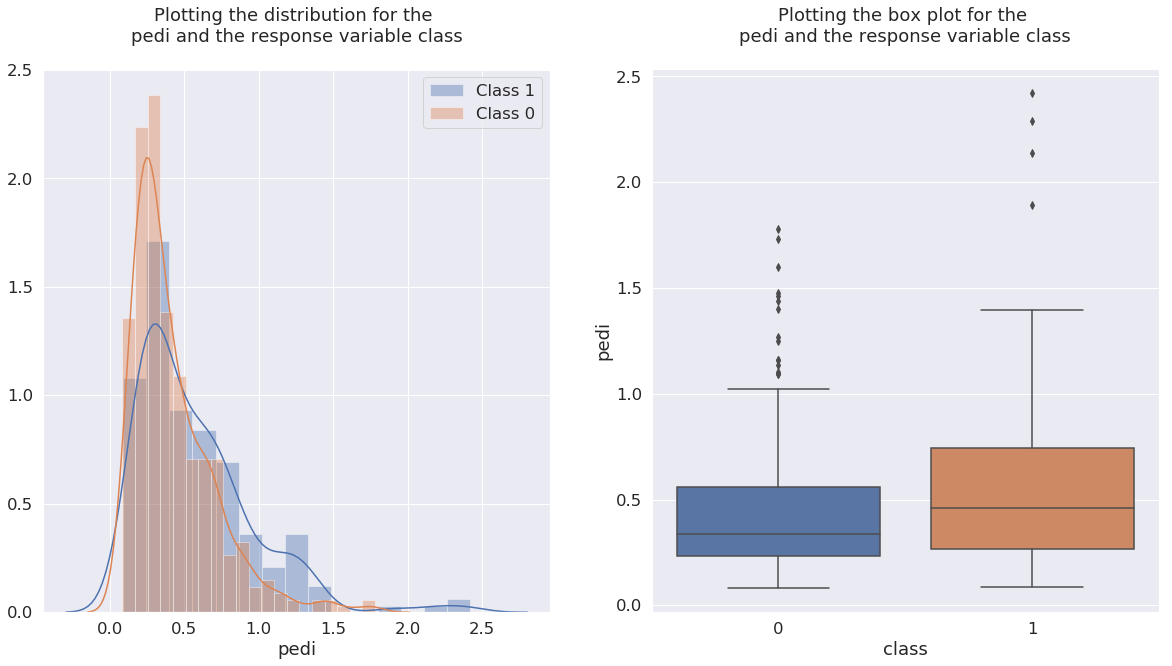


Analyzing the missing of the variable -- age

Descrbing the variable age we are exploring
count    614.000000
mean      33.151466
std       11.649511
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: age, dtype: float64

Correlating with all other variables 
preg     0.554559
plas     0.289140
pres     0.333449
mass     0.022280
pedi     0.024847
age      1.000000
class    0.247707
dtype: float64

count of zero values is 0


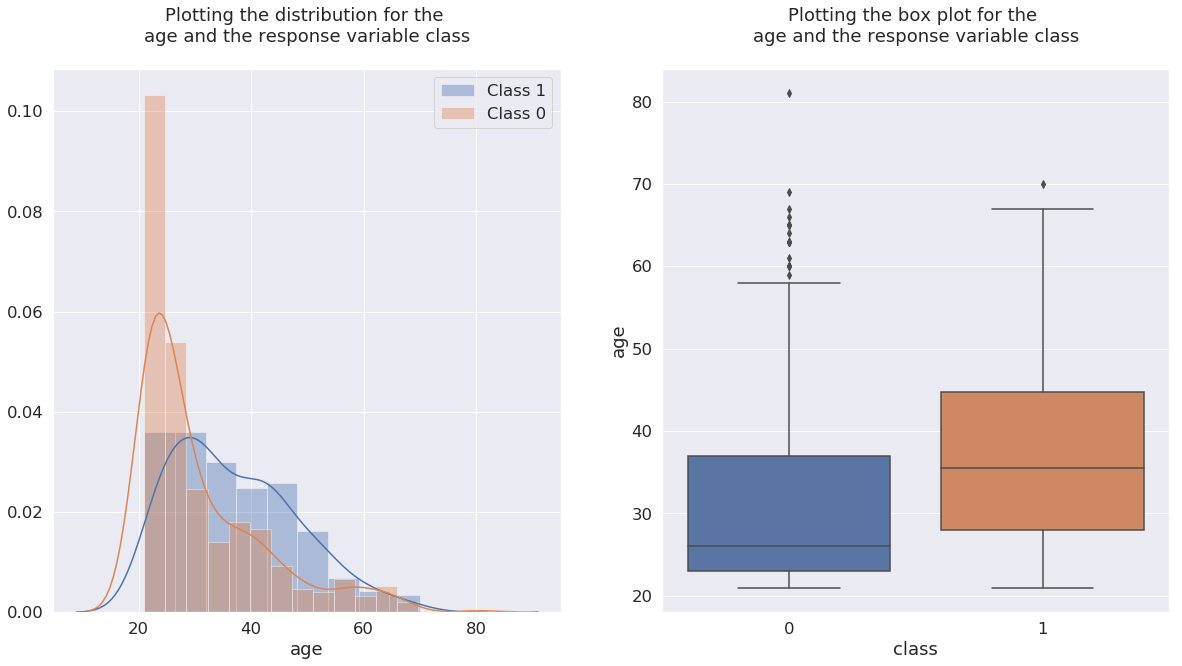

In [28]:
_tmp_x = pd.DataFrame(X_train, columns=["preg", "plas", "pres","mass","pedi","age"])
_tmp_y = pd.DataFrame(y_train.values, columns=['class'])
tmp = pd.concat([_tmp_x,_tmp_y], axis=1)
for column in tmp:
    if column != 'class':
        describe_var(tmp,column,'class')

In [29]:
# The function below would build the model from the train and test split datasets using the hyper-parameters kernel, 
# gammma and c values. For the polynomial kernel function the degree would be 2. This function would also print the metrics
# for the model performance and plot the roc, cumulative gain, lift curve and the learning curve. It will also print the 
# confusion matrix. 

def build_model(x_trn, y_trn, x_tst, y_tst, krnl,gam,c_value):
    svc = SVC(C=c_value, gamma=gam,kernel=krnl, degree=2, class_weight='balanced', cache_size=1000, probability=True) 
    clf = svc.fit(x_trn, y_trn) 
    
    y_pred = svc.predict(x_tst)
    y_probas = svc.predict_proba(x_tst)
    acc = accuracy_score(y_tst, y_pred)
    cm = confusion_matrix(y_tst, y_pred)
    report = classification_report(y_tst, y_pred)
    fpr, tpr, thresholds = roc_curve(y_tst, y_probas[:, 1])  
    roc_auc = auc(fpr, tpr)
    
    print('Model details \n',svc)
    print("\nPrediction accuracy:\n",acc)
    print('\nConfusion matrix is \n',cm)
    print('\nReport is \n',report) 
    print("\nfpr",fpr)
    print("\ntpr",tpr)
    print("\nthresholds", thresholds)
    print("\nAUC using predict_proba", roc_auc)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,20))
    skplt.metrics.plot_roc(y_tst, y_probas, ax=ax1)
    skplt.metrics.plot_cumulative_gain(y_tst, y_probas, ax=ax2)
    skplt.metrics.plot_lift_curve(y_tst, y_probas,ax=ax3)
    skplt.estimators.plot_learning_curve(clf, x_trn, y_trn,ax=ax4)
    plt.show()

    skplt.metrics.plot_confusion_matrix(y_tst, y_pred, normalize=True, figsize=(10,10))
    

Model details 
 SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prediction accuracy:
 0.649350649351

Confusion matrix is 
 [[100   0]
 [ 54   0]]

Report is 
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

   micro avg       0.65      0.65      0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154


fpr [ 0.    0.01  0.03  0.03  0.04  0.04  0.06  0.06  0.07  0.07  0.1   0.1
  0.13  0.13  0.16  0.16  0.19  0.19  0.2   0.2   0.21  0.21  0.24  0.24
  0.26  0.26  0.28  0.28  0.29  0.29  0.32  0.35  0.35  0.36  0.36  0.37
  0.37  0.42  0.42  0.46  0.46  0.6   0.6   0.61  0.61  0.63  0.63  0.68
  0.68  0.69  0.69  0.75  0.75  0

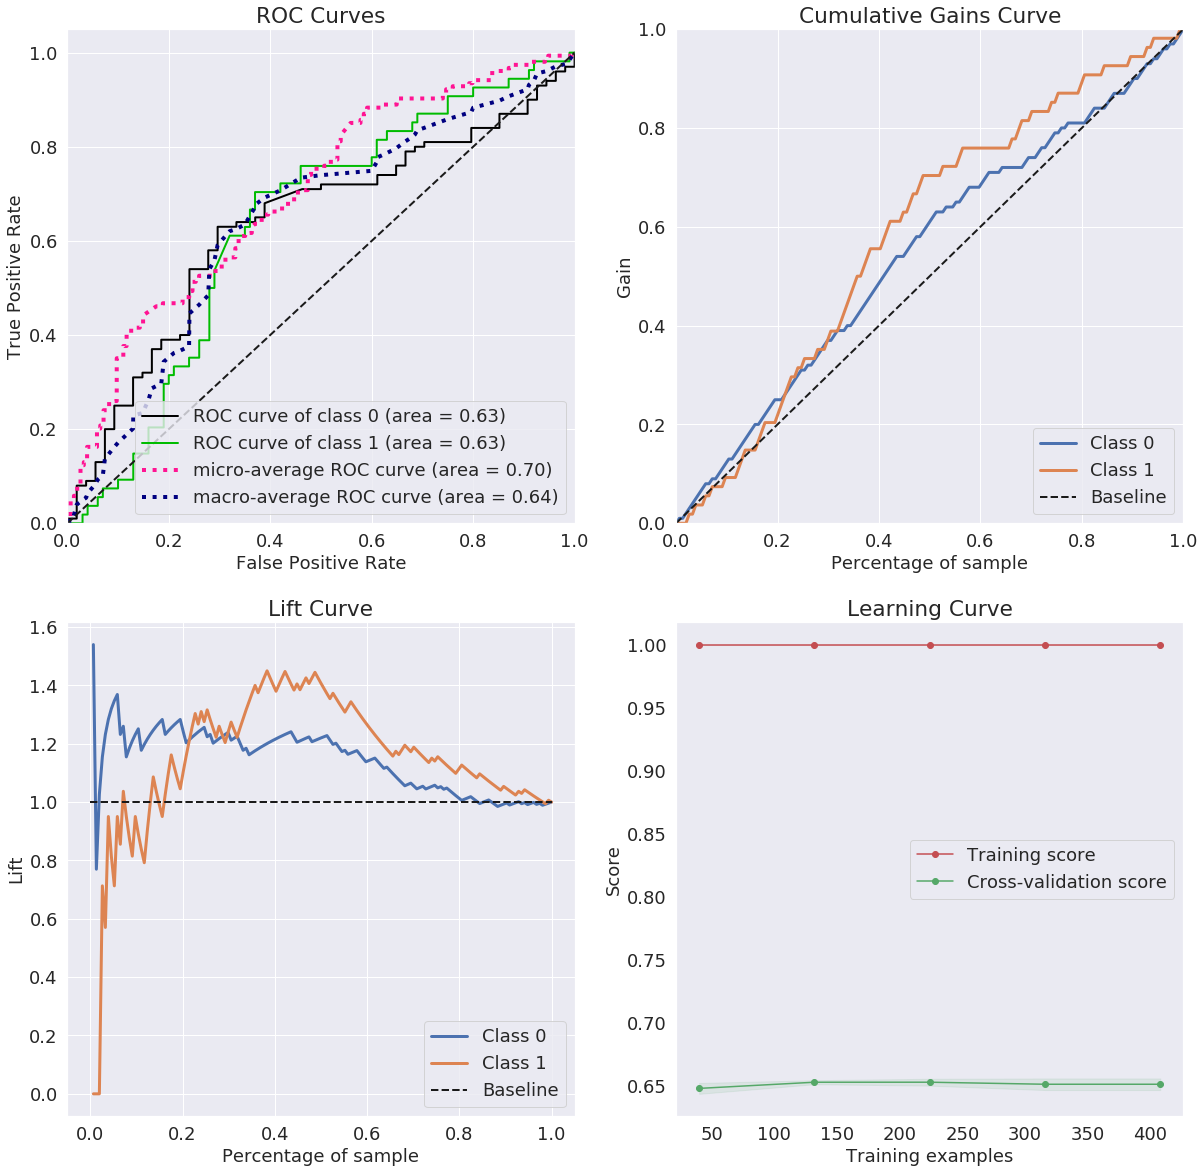

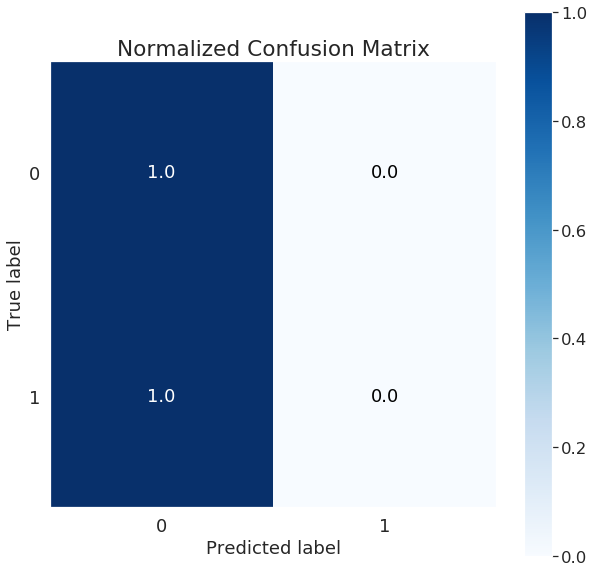

In [30]:
build_model(X_train, y_train, X_test, y_test, 'rbf','auto',1.0)

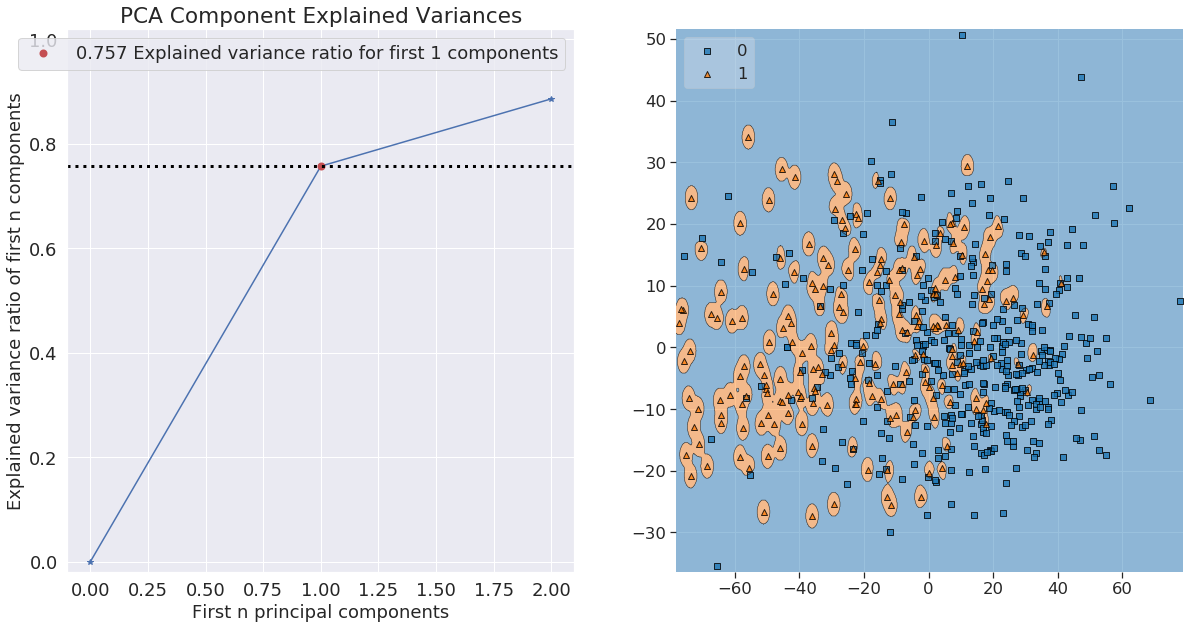

In [31]:
# After building the model. Similar hyper parameters are selected but only two priniciple components are choosen to plot 
# the serperation of the data points showing the decision region. We also plot the pca information. 

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train)
model = SVC(kernel='rbf', class_weight='balanced', cache_size=1000, probability=True) 
clf = model.fit(Xreduced, y_train)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
skplt.decomposition.plot_pca_component_variance(pca, ax=ax1)
plot_decision_regions(X=Xreduced, y=y_train.values, clf=clf, legend=2, ax=ax2)
plt.show()

# Need to scale the data
Performance of the initial model was very poor. Inorder to improve the performance of the model. The data is scaled and model is built again with 'rbf' kernel, gamma as auto and c value of 1.0.

In [32]:
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

Model details 
 SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prediction accuracy:
 0.727272727273

Confusion matrix is 
 [[77 23]
 [19 35]]

Report is 
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       100
           1       0.60      0.65      0.62        54

   micro avg       0.73      0.73      0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154


fpr [ 0.    0.01  0.01  0.02  0.02  0.03  0.03  0.04  0.04  0.06  0.06  0.07
  0.07  0.1   0.1   0.12  0.12  0.14  0.14  0.15  0.15  0.16  0.16  0.2
  0.2   0.23  0.23  0.24  0.24  0.25  0.25  0.27  0.27  0.31  0.31  0.32
  0.32  0.33  0.33  0.42  0.42  0.45  0.45  0.5   0.5   0.52  0.52  0.53
  0.53  0.6   0.6   0.93  0.93  1.  ]

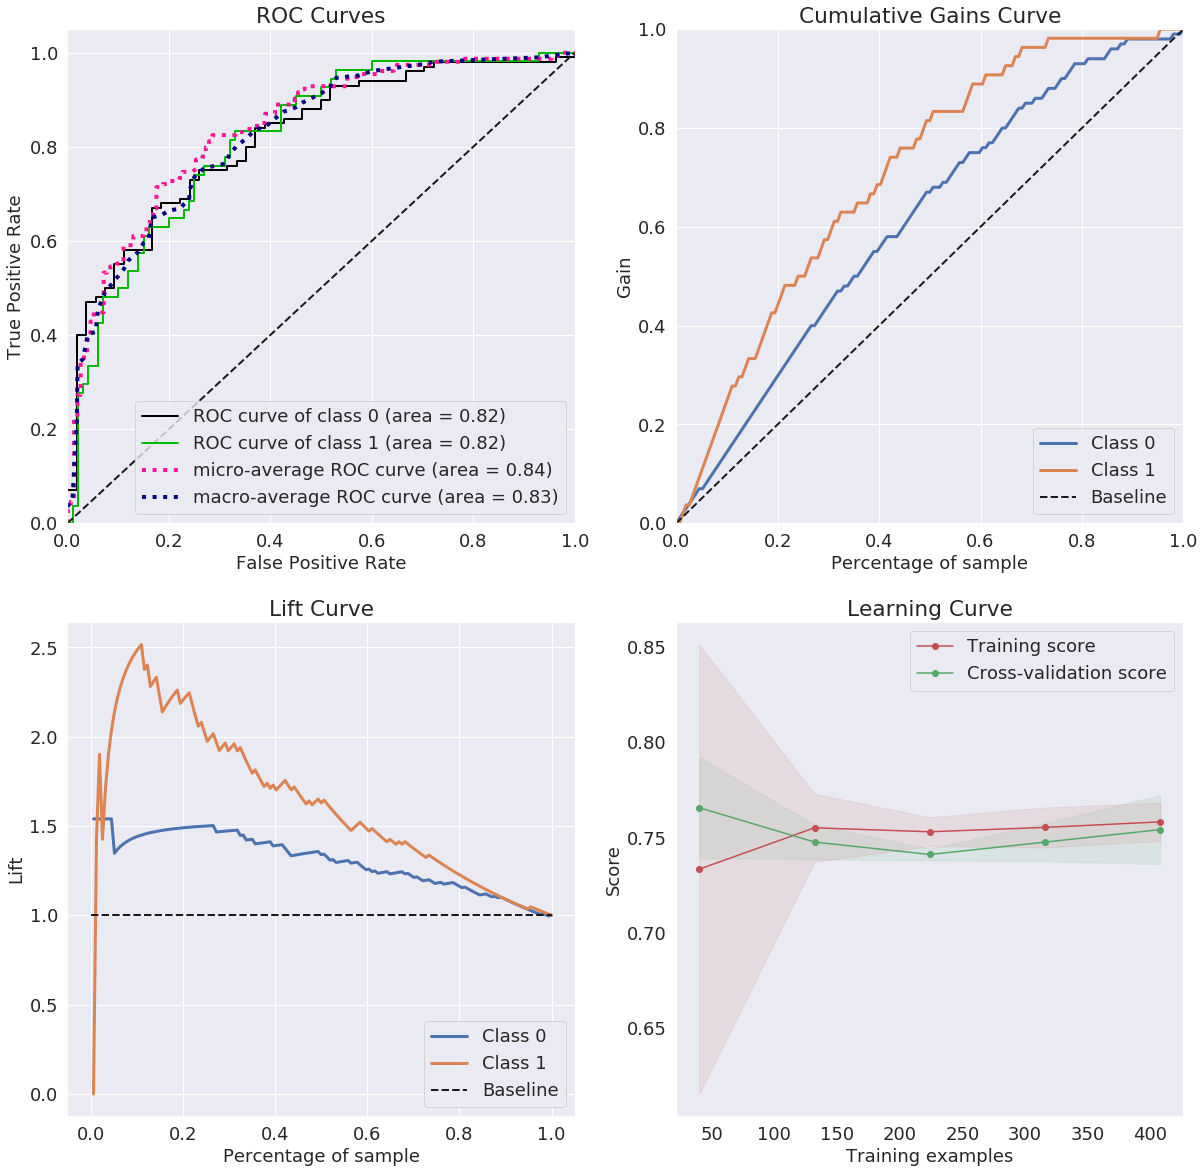

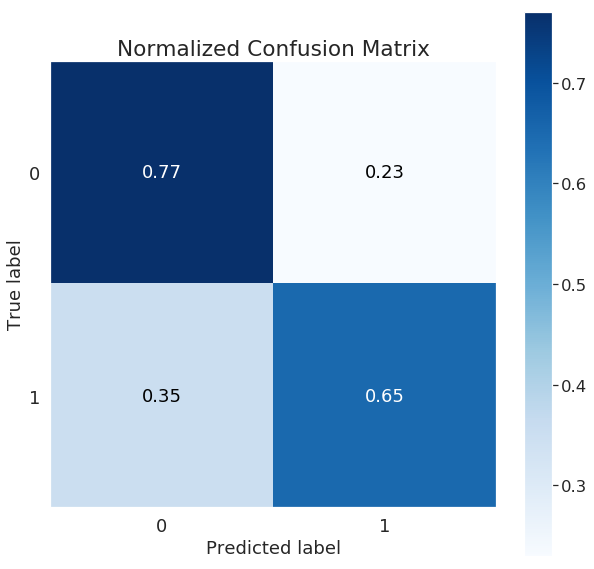

In [33]:
build_model(X_train_minmax, y_train, X_test_minmax, y_test, 'rbf','auto',1.0)

No handles with labels found to put in legend.


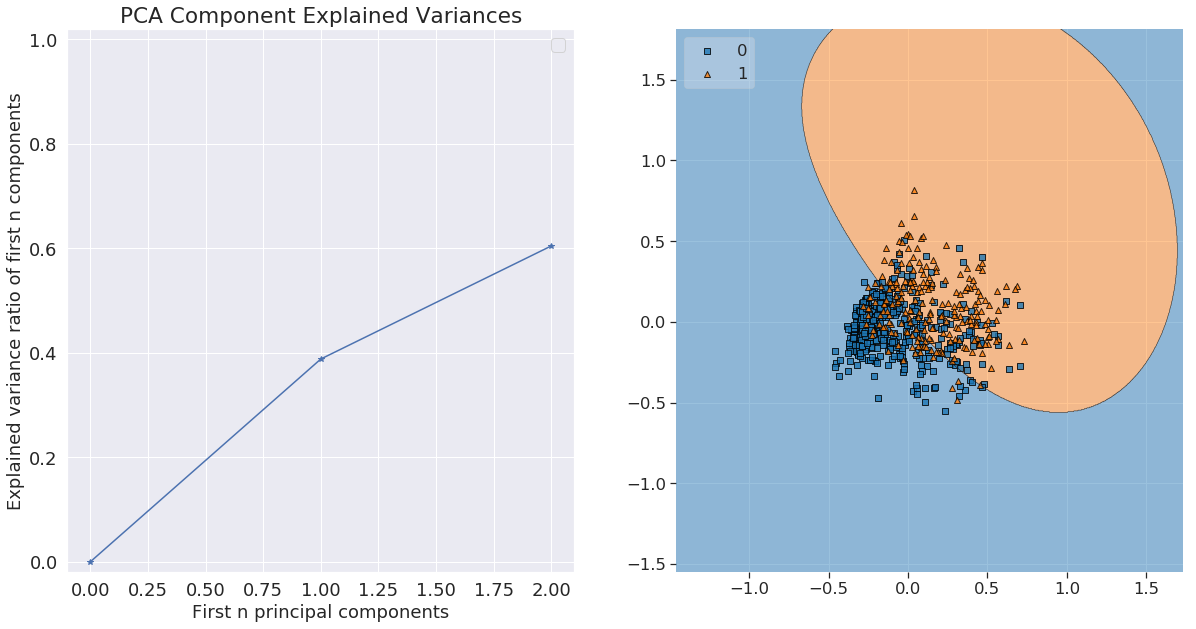

In [34]:
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train_minmax)
model = SVC(kernel='rbf', class_weight='balanced', cache_size=1000, probability=True) 
clf = model.fit(Xreduced, y_train)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
skplt.decomposition.plot_pca_component_variance(pca, ax=ax1)
plot_decision_regions(X=Xreduced, y=y_train.values, clf=clf, legend=2, ax=ax2)
plt.show()

## Performing Gridsearch
We got a decent performance. Hence this dataset would be used to preform a grid search for deciding the winning model. 

In [38]:
C_range = 10.0 ** np.arange(-2, 4)
gamma_range = [.01, .1, 1, 'auto', 10, 100]
kernels = ['rbf','poly']
param_grid = dict(gamma=gamma_range, C=C_range,kernel=kernels)
param_grid

{'gamma': [0.01, 0.1, 1, 'auto', 10, 100],
 'C': array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
          1.00000000e+01,   1.00000000e+02,   1.00000000e+03]),
 'kernel': ['rbf', 'poly']}

In [39]:
grid = GridSearchCV(SVC(cache_size=7000, degree =2, probability=True), param_grid=param_grid) 
grid.fit(X_train_minmax, y_train)
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print(best_C, best_gamma)
grid.best_estimator_

1000.0 100


SVC(C=1000.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=100, kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Winning model has the following hyper-parameters. 
C value of 1000, gamma value of 100, kernel is polynomial and degree 2. 

In [ ]:
build_model(X_train_minmax, y_train, X_test_minmax, y_test, 'poly',100,1000.0)

Model details 
 SVC(C=1000.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=100, kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prediction accuracy:
 0.753246753247

Confusion matrix is 
 [[73 27]
 [11 43]]

Report is 
               precision    recall  f1-score   support

           0       0.87      0.73      0.79       100
           1       0.61      0.80      0.69        54

   micro avg       0.75      0.75      0.75       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.75      0.76       154


fpr [ 0.    0.01  0.01  0.02  0.02  0.03  0.03  0.04  0.04  0.05  0.05  0.06
  0.06  0.07  0.07  0.08  0.08  0.09  0.09  0.1   0.1   0.13  0.13  0.15
  0.15  0.17  0.17  0.19  0.19  0.2   0.2   0.21  0.21  0.23  0.23  0.25
  0.25  0.27  0.27  0.29  0.29  0.3   0.3   0.31  0.31  0.36  0.36  0.4
  0.4   0.41  0.41  0.45  0.45  0.72

The final AUC is 0.83 with average f1 score of 0.76. Overall precision is 0.78 and recall 0.75